In [31]:
import pandas as pd 
import matplotlib.pyplot as plt 

### Load initial emission events created using simulated emission observations
##### each emission observation is one event 

In [32]:
df = pd.read_csv("Sample_site_simulated_observations_initial_events.csv",sep=',')

In [33]:
df.head(2)

,id,siteId,equipmentId,eventType,duration,detectedAt,startTime,endTime,rate,type,obs_names
0,e71e4e06-1940-4047-87df-2628de6fb5d6,SU-SITE-001,SU-SITE-001,Resolved Event,0.066667,2024-04-23 13:02,2024-04-23 13:02,2024-04-23 13:06,299.220075,ops,Vent-01
1,a85cb48e-c74a-4e3e-befa-21b16191516e,SU-SITE-001,SU-SITE-001,Resolved Event,0.100000,2024-04-19 15:57,2024-04-19 15:57,2024-04-19 16:03,184.108860,ops,Vent-02


In [34]:
#show attributes of emission event 
df.columns

Index(['id', 'siteId', 'equipmentId', 'eventType', 'duration', 'detectedAt',
       'startTime', 'endTime', 'rate', 'type', 'obs_names'],
      dtype='object')

##### description of emission observation data
- **id**: unique ID
- **siteId**: site ID of the fictitious site.
- **equipmentId**: equipment ID of for each piece of equipment in the fictitious site.
- **eventType**: event type of the initial event.
- **duration**: duration of the event.
- **detecetdAt**: detection time of each event.
  - For flyover, detectedAt is the time when plume detected by aircraft.
  - For CMS, detectedAt is the time when CMS alarm is triggered.
  - For operational events, detectedat is the start time of the operation.
- **startTime**: start time of the event.
- **endTime**: end time of the event.
- **rate**: flux rate of the emission.
- **type**: ops, flyover, cms indicating the type of the observation used to create initial event.
- **obs_name**: unique name of the observation used to create initial event. 

eventType
Partially Resovled Event    99
Resolved Event              73
Name: count, dtype: int64


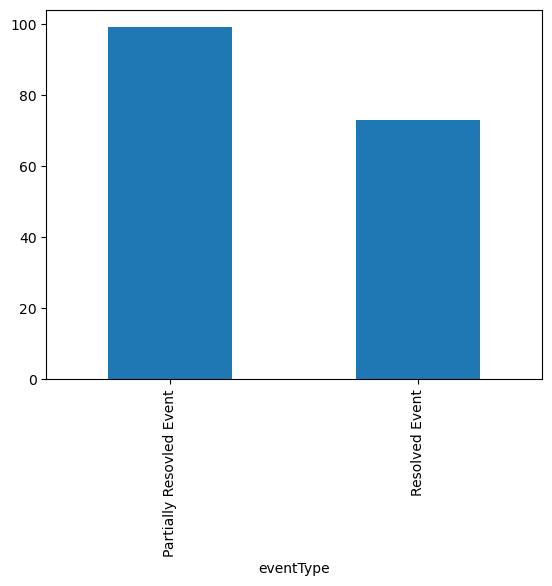

In [37]:
event_counts = df['eventType'].value_counts()
print(event_counts)
event_counts.plot(kind='bar')
plt.show()

### Merge events based on spatio-temporal correlations  
- Spatial aspect can be checked by using equipmentId associated with each event since they represnets the attributed physical source of a given event.
- Temporal aspect is checked by following temporal rules: temporal intersection and temporal inclusion. 

In [38]:
# Function to check if two intervals overlap, detection_time is within the range, and equipmentId is the same
def is_overlapping(start1, end1, detection_time1, start2, end2, detection_time2, equipmentId1, equipmentId2):
    return (not (end1 <= start2 or start1 >= end2)) and ((start1 <= detection_time2 <= end1) or (start2 <= detection_time1 <= end2) )and (equipmentId1 == equipmentId2)

In [39]:
# Function to assign labels after event merge iteratively 
def assign_labels(df):
    current_label = 1
    while df['label'].isnull().any():
        # Find the index of the first unlabelled row
        idx = df.index[df['label'].isnull()].min()
        # Get the start, end, detection time, and equipmentId of this row
        start_time = df.at[idx, 'startTime']
        end_time = df.at[idx, 'endTime']
        detection_time = df.at[idx, 'detectedAt']
        equipmentId = df.at[idx, 'equipmentId']
        # Create a list of indices to process
        indices_to_process = [idx]
        
        while indices_to_process:
            current_idx = indices_to_process.pop(0)
            df.at[current_idx, 'label'] = current_label
            # Find all rows that overlap with the current row, have detection_time within range, and the same equipmentId
            overlapping_indices = df.index[(df['label'].isnull()) & 
                                           (df.apply(lambda row: is_overlapping(start_time, end_time, detection_time, 
                                                                                row['startTime'], row['endTime'], 
                                                                                row['detectedAt'], equipmentId, 
                                                                                row['equipmentId']), axis=1))].tolist()
            # Add these overlapping indices to the list of indices to process
            indices_to_process.extend(overlapping_indices)
        
        current_label += 1

In [47]:
# assign label to each event based on spatio-temporal correlation
df['label'] = pd.Series(dtype='int')
assign_labels(df)

In [48]:
df["label"].unique()

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.])

In [49]:
# assign unique event name to each event before merge 
event_names = [] 
for _,row in df.iterrows(): 
    event_names.append(f"Event-{str(int(row.label)).zfill(2)}")  

In [50]:
df["event_names"] = event_names

In [59]:
# merge event based on spatio-temporal correlations
# merged events will be used in the reconciliation  
merged_event = [] 
re_rates = [] 
test = []
j = 172
for la in df["label"].unique():
    ldf = df[df["label"] == la] 
    if len(ldf) == 1:
        obsType = ldf.type.iloc[0]
        if obsType == "ops":
           measured_rate = None 
           measured_duration = None 
           measured_startTime = None 
           measured_endTime = None
           measured_quantity = None
           calculated_duration = ldf.duration.iloc[0] 
           calculated_quantity = ldf.rate.iloc[0] * ldf.duration.iloc[0] 
           calculated_startTime = ldf.startTime.iloc[0] 
           calculated_endTime = ldf.endTime.iloc[0] 
        else: 
           calculated_duration = None 
           calculated_quantity = None 
           calculated_startTime = None 
           calculated_endTime = None 
           measured_rate =ldf.rate.iloc[0]
           measured_duration = ldf.duration.iloc[0] 
           measured_startTime = ldf.startTime.iloc[0] 
           measured_endTime = ldf.endTime.iloc[0] 
           measured_quantity = measured_rate * measured_duration
        merged_event.append({
            "id":ldf.id.iloc[0],
            "siteId": "SU-SITE-001",
            "equipmentId": ldf.equipmentId.iloc[0],
            "eventType": ldf.eventType.iloc[0],
            "measured_rate":measured_rate,
            "measured_duration":measured_duration,
            "measured_quantity":measured_quantity,
            "measured_startTime": measured_startTime, 
            "measured_endTime": measured_endTime, 
            "calculated_duration":calculated_duration,
            "calculated_quantity":calculated_quantity,
            "calculated_startTime": calculated_startTime, 
            "calculated_endTime": calculated_endTime,
        })
    else: 
        flyover_rate = ldf.rate.iloc[0]
        flyover_duration = ldf.duration.iloc[0]
        flyover_quantity = flyover_rate * flyover_duration

        vfb_quantity = 0 
        vfb_duration = 0
        for index,row in ldf.iterrows():
            if index > 0: 
                vfb_quantity += row.rate * row.duration
                vfb_duration += row.duration
        merged_event.append({
                "id": ldf.id.iloc[0],
                "siteId":"SU-SITE-001",
                "equipmentId":ldf.equipmentId.iloc[0],
                "eventType":"Resolved Event",
                "measured_rate":flyover_rate,
                "measured_duration":flyover_duration,
                "measured_quantity":flyover_quantity,
                "measured_startTime": ldf.startTime.iloc[0], 
                "measured_endTime": ldf.endTime.iloc[0], 
                "calculated_duration":vfb_duration,
                "calculated_quantity":vfb_quantity,
                "calculated_startTime": ldf.startTime.iloc[1], 
                "calculated_endTime": ldf.endTime.iloc[-1], 
                })
    j += 1 

In [60]:
m_events = pd.DataFrame(merged_event)

eventType
Resolved Event              90
Partially Resovled Event    53
Name: count, dtype: int64


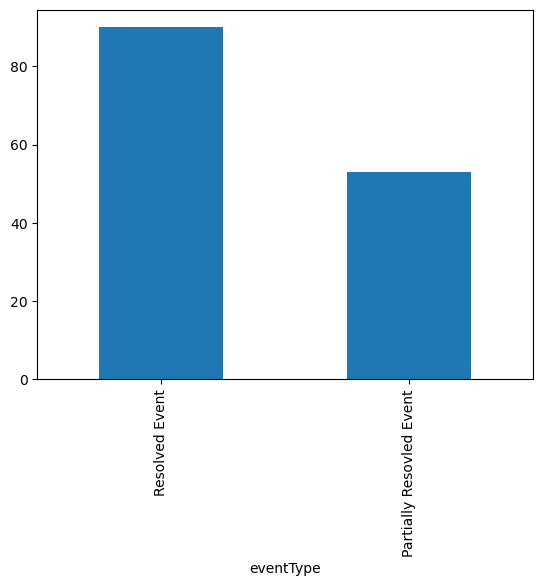

In [61]:
event_counts = m_event['eventType'].value_counts()
print(event_counts)
event_counts.plot(kind='bar')
plt.show()

In [62]:
m_events.to_csv("merged_events.csv",sep=',', index=False)

In [63]:
m_events.head(3)

,id,siteId,equipmentId,eventType,measured_rate,measured_duration,measured_quantity,measured_startTime,measured_endTime,calculated_duration,calculated_quantity,calculated_startTime,calculated_endTime
0,e71e4e06-1940-4047-87df-2628de6fb5d6,SU-SITE-001,SU-SITE-001,Resolved Event,299.220075,0.066667,19.948005,2024-04-23 13:02,2024-04-23 13:06,1444.633333,27803.370987,2024-03-01 19:22,2024-05-01 0:00
1,a85cb48e-c74a-4e3e-befa-21b16191516e,SU-SITE-001,SU-SITE-001,Resolved Event,NaN,NaN,NaN,None,None,0.100000,18.410886,2024-04-19 15:57,2024-04-19 16:03
2,5f674067-187a-4080-a540-d5ba50e13af9,SU-SITE-001,SU-SITE-001,Resolved Event,NaN,NaN,NaN,None,None,0.066667,25.376856,2024-04-19 14:48,2024-04-19 14:52
